In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sn
import networkx as nx
import os
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
print(os.getcwd())

/content


In [ ]:
ra_data = pd.read_csv("/content/arthritis.csv")
ra_data.head()

,Patients,Condition,ARRDC5,FAM86C1,RAB3D,MORC2,ZNF600,SNAPC5,ZNF675,SFT2D1,...,LOC728534,SNORA24,CCT6P1,CCT6P3,SNORA22,RPL32P3,SNORA7A,SNORA7B,SNORA70,SNORA70G
0,GSM2981057,Healthy,5.598697,4.046514,4.792378,4.889926,6.614537,6.850238,3.627961,9.267813,...,4.782302,6.154111,5.863219,5.863219,5.863219,6.764443,6.764443,6.764443,5.183177,5.183177
1,GSM2981058,Healthy,5.566074,3.927057,4.885309,4.317204,6.634278,7.367398,4.292509,9.337131,...,4.944751,5.920788,6.022412,6.022412,6.022412,7.141088,7.141088,7.141088,4.940929,4.940929
2,GSM2981059,Healthy,5.102207,4.436170,4.440248,5.011531,7.082590,6.813552,4.041210,9.182283,...,4.188737,6.326932,5.573319,5.573319,5.573319,7.089928,7.089928,7.089928,4.777421,4.777421
3,GSM2981060,Healthy,4.855702,3.573448,4.805659,5.458887,7.385368,7.331518,3.712238,8.804739,...,3.931559,5.777944,6.063390,6.063390,6.063390,6.930789,6.930789,6.930789,4.906627,4.906627
4,GSM2981061,Healthy,5.151591,4.228044,4.906295,4.540327,7.299135,7.191299,3.749823,9.475676,...,4.856008,5.650359,6.103134,6.103134,6.103134,7.140819,7.140819,7.140819,4.924967,4.924967


In [ ]:
healthy_data = ra_data[ra_data['Condition'] == 'Healthy']
unhealthy_data = ra_data[ra_data['Condition'] == 'Unhealthy']

In [ ]:
# Extract the gene names and initialize a DataFrame to store p-values
genes = ra_data.columns[2:]  # Assuming gene columns start from the third column

# Create a dictionary to store gene names and their corresponding p-values
gene_p_values = {'Gene': [], 'P-Value': []}

# Perform t-tests for each gene and store the results in the dictionary
for gene in genes:
    p_value = ttest_ind(healthy_data[gene], unhealthy_data[gene]).pvalue
    gene_p_values['Gene'].append(gene)
    gene_p_values['P-Value'].append(p_value)

# Create a DataFrame from the dictionary
p_values_data = pd.DataFrame(gene_p_values)

In [ ]:
p_values_data

,Gene,P-Value
0,ARRDC5,0.000042
1,FAM86C1,0.002731
2,RAB3D,0.197705
3,MORC2,0.023675
4,ZNF600,0.000008
...,...,...
10909,RPL32P3,0.000248
10910,SNORA7A,0.000248
10911,SNORA7B,0.000248
10912,SNORA70,0.000043


In [ ]:
# Perform multiple testing correction (FDR correction)
corrected_p_values = multipletests(p_values_data['P-Value'], method='fdr_bh')[1]

# Add corrected p-values to the DataFrame
p_values_data['Corrected P-Value'] = corrected_p_values

In [ ]:
significance_threshold = 0.1
significant_genes = p_values_data[p_values_data['Corrected P-Value'] < significance_threshold]

In [ ]:
significant_genes

,Gene,P-Value,Corrected P-Value
0,ARRDC5,0.000042,0.000174
1,FAM86C1,0.002731,0.006260
3,MORC2,0.023675,0.040923
4,ZNF600,0.000008,0.000043
6,ZNF675,0.000003,0.000019
...,...,...,...
10909,RPL32P3,0.000248,0.000796
10910,SNORA7A,0.000248,0.000796
10911,SNORA7B,0.000248,0.000796
10912,SNORA70,0.000043,0.000177


In [ ]:
# Save the significant genes to a new CSV file
significant_genes.to_csv('significant_genes.csv', index=False)

In [ ]:
significant_genes.head()

,Gene,P-Value,Corrected P-Value
0,ARRDC5,0.000042,0.000174
1,FAM86C1,0.002731,0.006260
3,MORC2,0.023675,0.040923
4,ZNF600,0.000008,0.000043
6,ZNF675,0.000003,0.000019


In [ ]:
significant_genes.to_csv('/significant_genes.csv', index=False)

In [ ]:
# Load your sorted genes CSV with expression values
imp_genes = pd.read_csv('/content/important_genes.csv')

In [ ]:
imp_genes['Condition'] = imp_genes['Condition'].map({'Healthy': 0, 'Unhealthy': 1})

X = imp_genes.drop('Condition', axis=1)  # Features (gene expression values)
y = imp_genes['Condition']  # Target (0 for Healthy, 1 for Unhealthy)

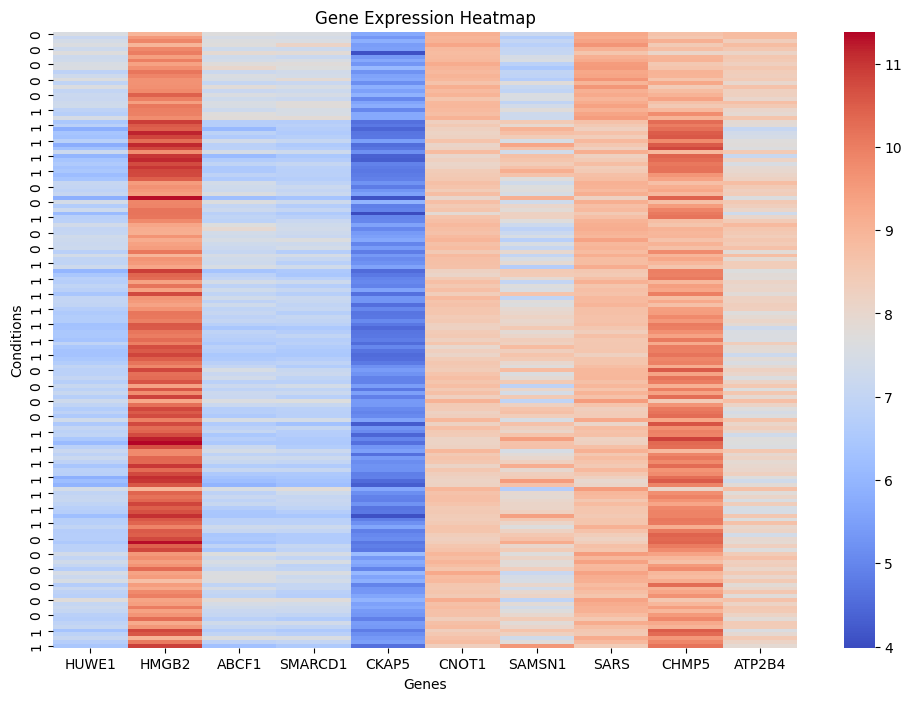

In [ ]:
# Set the 'Condition' column as the index for better visualization
imp_genes.set_index('Condition', inplace=True)

# Now you can create a heatmap
plt.figure(figsize=(12, 8))  # Adjust the figure size as needed
sn.heatmap(imp_genes, cmap='coolwarm', cbar=True)

# Customize labels and title
plt.xlabel('Genes')
plt.ylabel('Conditions')
plt.title('Gene Expression Heatmap')

# Show the plot
plt.show()

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize a classifier (Random Forest in this example)
classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier on the training data
classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
#Make predictions on the test data
y_pred = classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Get a classification report for more detailed metrics
classification_rep = classification_report(y_test, y_pred)
print(classification_rep)

Accuracy: 0.79
              precision    recall  f1-score   support

           0       0.80      0.84      0.82        19
           1       0.77      0.71      0.74        14

    accuracy                           0.79        33
   macro avg       0.78      0.78      0.78        33
weighted avg       0.79      0.79      0.79        33



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [ ]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.73
